In [1]:
# python 3.6.8
import math
import scipy
from scipy.stats import normaltest
from scipy.stats import anderson

import sklearn
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import mean_absolute_error, max_error, median_absolute_error
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.stattools import medcouple
from statsmodels.graphics.gofplots import qqplot

import xgboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Look on data

In [2]:
# read dataset
df = pd.read_csv('motorbike_ambulance_calls.csv')
# drop index
df = df[df.columns.difference(['index'])]
# check for nan
df.isnull().any().sum()

0

In [3]:
# correlation matrix
df.corr().style.background_gradient(cmap='coolwarm')

In [4]:
# general stat params
df.describe()

atemp           cnt       holiday            hr           hum  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775    189.463088      0.028770     11.546752      0.627229   
std        0.171850    181.387599      0.167165      6.914405      0.192930   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        0.333300     40.000000      0.000000      6.000000      0.480000   
50%        0.484800    142.000000      0.000000     12.000000      0.630000   
75%        0.621200    281.000000      0.000000     18.000000      0.780000   
max        1.000000    977.000000      1.000000     23.000000      1.000000   

               mnth          temp    weathersit       weekday     windspeed  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       6.537775      0.496987      1.425283      3.003683      0.190098   
std        3.438776      0.192556      0.639357      2.005771      0.122340   
min        1.000000      0.020000      1.000000      0.000000      0.000000   
25%        4.000000      0.340000      1.000000      1.000000      0.104500   
50%        7.000000      0.500000      1.000000      3.000000      0.194000   
75%       10.000000      0.660000      2.000000      5.000000      0.253700   
max       12.000000      1.000000      4.000000      6.000000      0.850700   

         workingday            yr  
count  17379.000000  17379.000000  
mean       0.682721      0.502561  
std        0.465431      0.500008  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      1.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

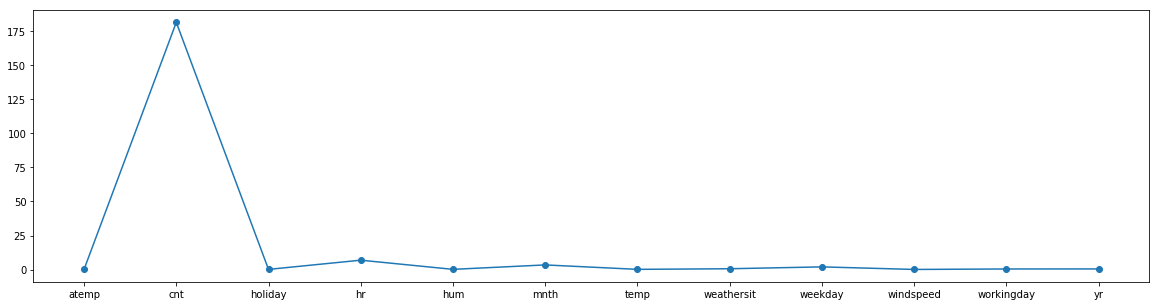

In [5]:
# plot std's
plt.figure(figsize=(20,5))
plt.plot(df.std(), marker='o')

Plot all non nominative features

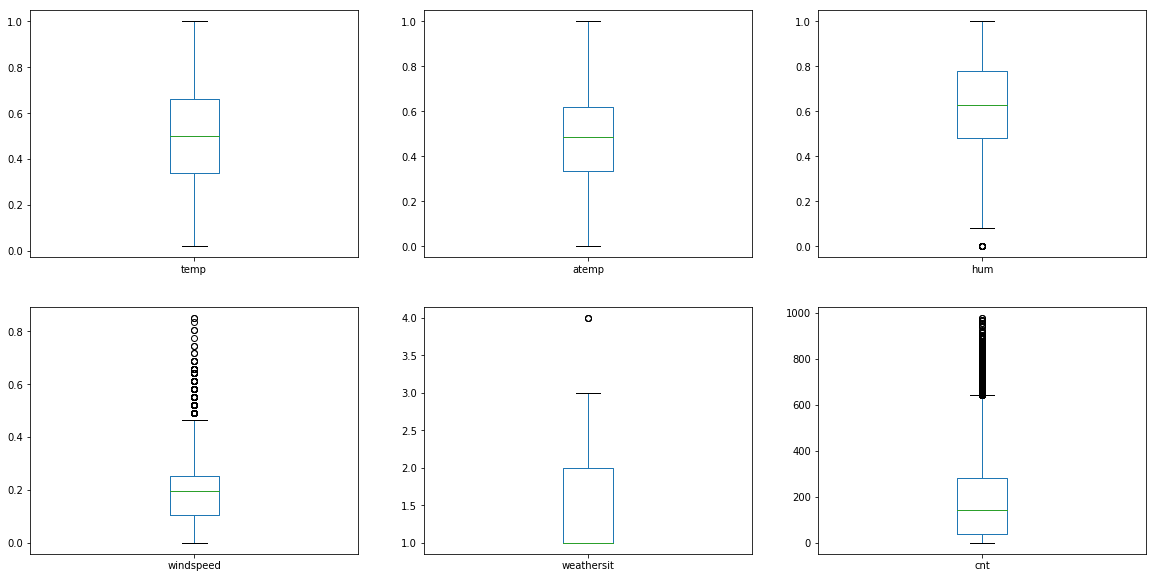

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for xcol, ax in zip(df[['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt']], axes.flat):
    df.boxplot(xcol, ax=ax, grid=False)

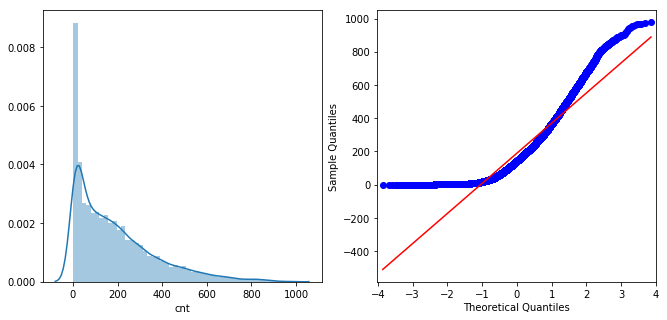

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
sns.distplot(df['cnt'], norm_hist=True, ax=axes[0])
qqplot(df['cnt'], line='s', ax=axes[1])
plt.show()

Do formal normality tests

In [9]:
stat, p = normaltest(df['cnt'])
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

result = anderson(df['cnt'])

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Sample does not look Gaussian (reject H0)
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [10]:
# Hubert, M.; Vandervieren, E. (2008). "An adjusted boxplot for skewed distribution".
# Computational Statistics and Data Analysis. 52 (12): 5186–5201. CiteSeerX 10.1.1.90.9812.
# doi:10.1016/j.csda.2007.11.008.

Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1
MC = medcouple(df.cnt.values)
if MC >= 0:
    lb = Q1 - 1.5 * math.e **(-4*MC) * IQR
    ub = Q3 + 1.5 * math.e **(3*MC) * IQR
else:
    lb = Q1 - 1.5 * math.e **(-3*MC) * IQR
    ub = Q3 + 1.5 * math.e **(4*MC) * IQR


# for skew distr
no_outliers_mask = (df['cnt'] >= lb) & (df['cnt'] <= ub)

In [11]:
# False -- no outliers
~no_outliers_mask.any()

False

So it is far from normal

In [12]:
def plot_all(df):
    scatter_plots = ['temp', 'hum', 'windspeed', 'atemp']
    bar_plots = ['season', 'mnth', 'weekday', 'workingday', 'holiday', 'hr', 'weathersit']

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20))
    for xcol, ax in zip(df[scatter_plots], axes.flat[:4]):
        tmp = df.groupby(xcol)['cnt'].sum()
        ax.scatter(tmp.index, tmp.values, marker='o')
        ax.set(xlabel=xcol, ylabel='cnt')

    for xcol, ax in zip(df[bar_plots], axes.flat[4:-1]):
        tmp = df.groupby(xcol)['cnt'].sum()
        ax.bar(tmp.index, tmp.values)
        ax.set(xlabel=xcol, ylabel='cnt', xticks=tmp.index)

    sns.distplot(df.groupby(['date'])['cnt'].sum(), norm_hist=True, ax=axes.flat[-1])
    plt.xlabel("cnt by date norm_hist")

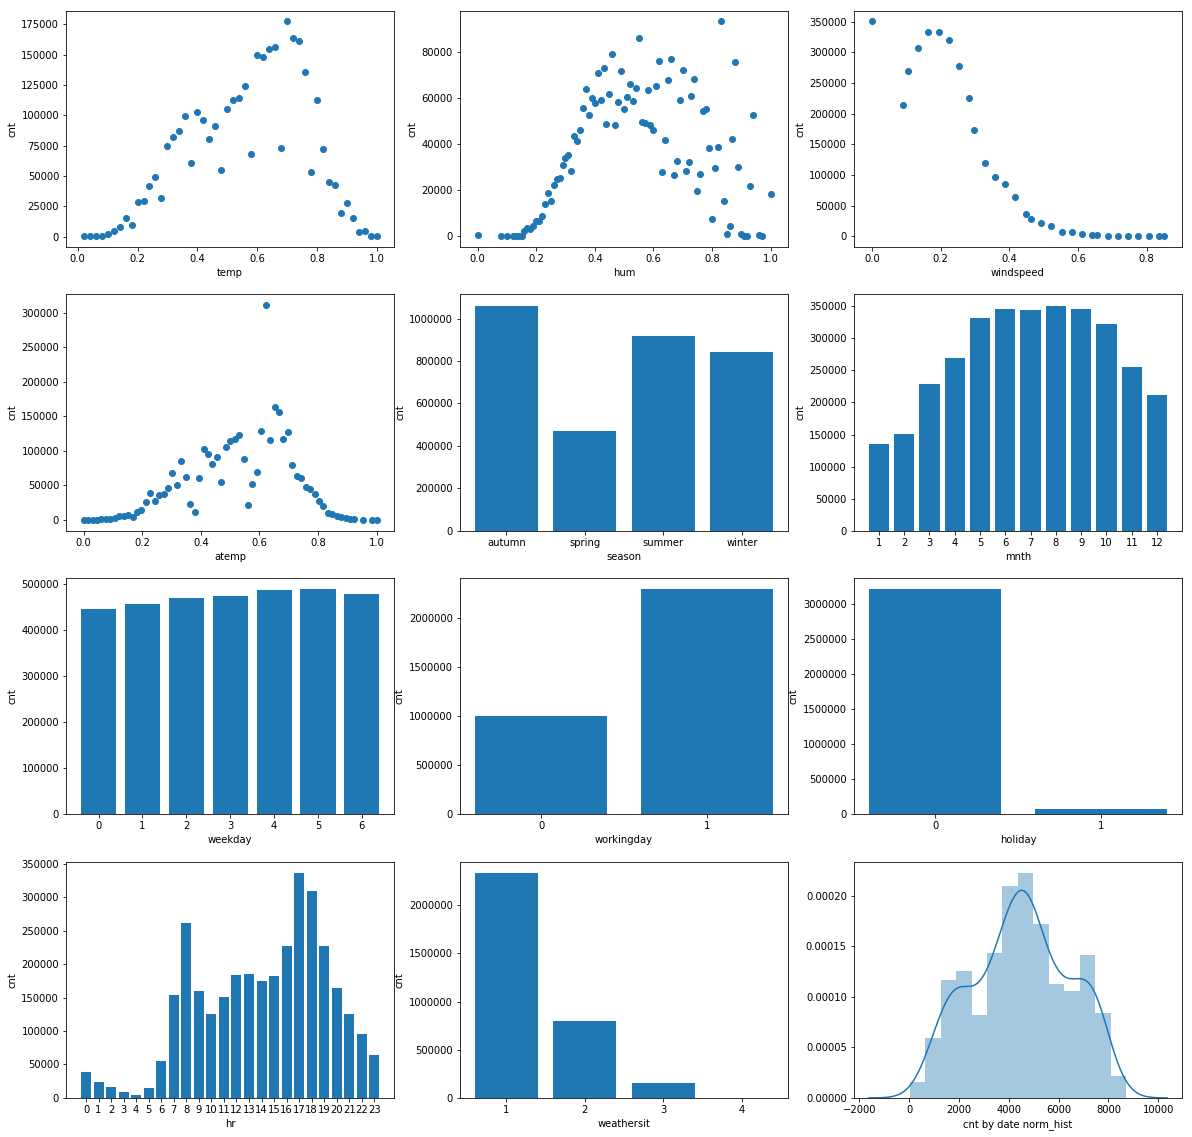

In [13]:
plot_all(df)

## Train

In [14]:
mask = df.columns.difference(['yr', 'date', 'season', 'atemp'])


main = df[no_outliers_mask][mask]

train=main.sample(frac=0.8, random_state=18)
test=main.drop(train.index)

train_y = train['cnt']
train_x = train.drop(['cnt'], axis=1)
test_y = test['cnt']
test_x = test.drop(['cnt'], axis=1)


In [15]:
# no monotonic features found on graphs
model = xgboost.XGBRegressor(
                 n_estimators=3000,       
                 learning_rate=0.01,
                 verbosity=0,
                 seed=10) 

In [16]:

eval_s=[(train_x, train_y),(test_x, test_y)]

### Grid search

In [17]:
# test_params = {
#  'max_depth':[6,8,12],
#  'gamma': [0.05, 0.1, 0.2],
#  'alpha': [0.1, 0.3],
#  'learning_rate': [0.01, 0.05, 0.1]
# }

# test_model = GridSearchCV(estimator = model, param_grid = test_params)

# test_model.fit(train_x, train_y, eval_set=eval_s, early_stopping_rounds=10)

# model.set_params(**test_model.best_params_) == best_params

### Train with best params

In [18]:
best_params = {'alpha': 0.1, 'gamma': 0.2, 'max_depth': 8, 'learning_rate': 0.05}
model.set_params(**best_params)

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.2,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=10,
             silent=None, subsample=1, verbosity=0)

In [19]:
model.fit(train_x, train_y, eval_set=eval_s, early_stopping_rounds=10)

[0]	validation_0-rmse:250.937	validation_1-rmse:247.911
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:239.815	validation_1-rmse:236.99
[2]	validation_0-rmse:229.289	validation_1-rmse:226.702
[3]	validation_0-rmse:219.344	validation_1-rmse:216.903
[4]	validation_0-rmse:209.916	validation_1-rmse:207.623
[5]	validation_0-rmse:201.11	validation_1-rmse:198.952
[6]	validation_0-rmse:192.704	validation_1-rmse:190.701
[7]	validation_0-rmse:184.892	validation_1-rmse:183.017
[8]	validation_0-rmse:177.496	validation_1-rmse:175.78
[9]	validation_0-rmse:170.565	validation_1-rmse:168.962
[10]	validation_0-rmse:164.004	validation_1-rmse:162.545
[11]	validation_0-rmse:157.823	validation_1-rmse:156.497
[12]	validation_0-rmse:152.033	validation_1-rmse:150.819
[13]	validation_0-rmse:146.505	validation_1-rmse:145.385
[14]	validation_0-rmse:141.312	validation_1-rmse:140.355

[141]	validation_0-rmse:50.7695	validation_1-rmse:63.9039
[142]	validation_0-rmse:50.6796	validation_1-rmse:63.8608
[143]	validation_0-rmse:50.6673	validation_1-rmse:63.8615
[144]	validation_0-rmse:50.586	validation_1-rmse:63.832
[145]	validation_0-rmse:50.535	validation_1-rmse:63.8059
[146]	validation_0-rmse:50.4355	validation_1-rmse:63.7992
[147]	validation_0-rmse:50.3697	validation_1-rmse:63.7685
[148]	validation_0-rmse:50.3154	validation_1-rmse:63.7529
[149]	validation_0-rmse:50.2589	validation_1-rmse:63.7491
[150]	validation_0-rmse:50.1945	validation_1-rmse:63.7135
[151]	validation_0-rmse:50.1578	validation_1-rmse:63.6796
[152]	validation_0-rmse:49.986	validation_1-rmse:63.6772
[153]	validation_0-rmse:49.947	validation_1-rmse:63.6693
[154]	validation_0-rmse:49.8649	validation_1-rmse:63.6497
[155]	validation_0-rmse:49.8231	validation_1-rmse:63.6306
[156]	validation_0-rmse:49.7222	validation_1-rmse:63.6306
[157]	validation_0-rmse:49.6874	validation_1-rmse:63.6104
[158]	validation_0-

[283]	validation_0-rmse:42.8834	validation_1-rmse:61.7629
[284]	validation_0-rmse:42.849	validation_1-rmse:61.7412
[285]	validation_0-rmse:42.7971	validation_1-rmse:61.7345
[286]	validation_0-rmse:42.7371	validation_1-rmse:61.7425
[287]	validation_0-rmse:42.6396	validation_1-rmse:61.7192
[288]	validation_0-rmse:42.6032	validation_1-rmse:61.7118
[289]	validation_0-rmse:42.5601	validation_1-rmse:61.7295
[290]	validation_0-rmse:42.5284	validation_1-rmse:61.7298
[291]	validation_0-rmse:42.517	validation_1-rmse:61.7318
[292]	validation_0-rmse:42.4168	validation_1-rmse:61.699
[293]	validation_0-rmse:42.3531	validation_1-rmse:61.678
[294]	validation_0-rmse:42.2958	validation_1-rmse:61.6733
[295]	validation_0-rmse:42.2385	validation_1-rmse:61.6445
[296]	validation_0-rmse:42.1756	validation_1-rmse:61.6283
[297]	validation_0-rmse:42.1208	validation_1-rmse:61.6292
[298]	validation_0-rmse:42.008	validation_1-rmse:61.605
[299]	validation_0-rmse:41.9075	validation_1-rmse:61.5802
[300]	validation_0-r

[426]	validation_0-rmse:36.4893	validation_1-rmse:60.6783
[427]	validation_0-rmse:36.4871	validation_1-rmse:60.6785
[428]	validation_0-rmse:36.4805	validation_1-rmse:60.6757
[429]	validation_0-rmse:36.4409	validation_1-rmse:60.6693
[430]	validation_0-rmse:36.3995	validation_1-rmse:60.6568
[431]	validation_0-rmse:36.3668	validation_1-rmse:60.6448
[432]	validation_0-rmse:36.3646	validation_1-rmse:60.6457
[433]	validation_0-rmse:36.3547	validation_1-rmse:60.6424
[434]	validation_0-rmse:36.3526	validation_1-rmse:60.6433
[435]	validation_0-rmse:36.3441	validation_1-rmse:60.639
[436]	validation_0-rmse:36.2832	validation_1-rmse:60.6326
[437]	validation_0-rmse:36.2331	validation_1-rmse:60.6434
[438]	validation_0-rmse:36.2036	validation_1-rmse:60.6344
[439]	validation_0-rmse:36.1772	validation_1-rmse:60.6244
[440]	validation_0-rmse:36.1298	validation_1-rmse:60.6279
[441]	validation_0-rmse:36.0882	validation_1-rmse:60.6371
[442]	validation_0-rmse:35.9804	validation_1-rmse:60.6148
[443]	validatio

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.2,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=10,
             silent=None, subsample=1, verbosity=0)

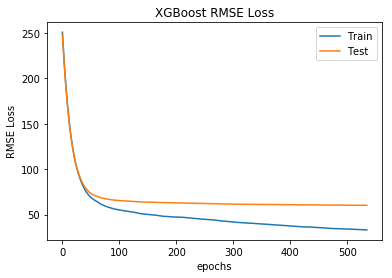

In [25]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE Loss')
plt.xlabel('epochs')
plt.title('XGBoost RMSE Loss')
plt.show()

In [20]:
# R^2
print('R^2 for train: ', model.score(train_x, train_y))
print('R^2 for test:', model.score(test_x,test_y))

R^2 for train:  0.9661410517073493
R^2 for test: 0.8869382954065403


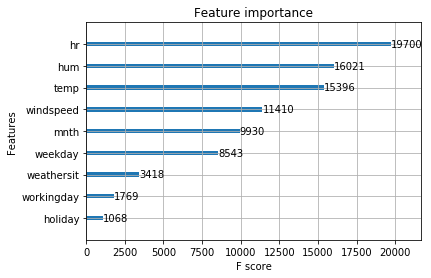

In [21]:
xgboost.plot_importance(model)

In [22]:
y_predicted = model.predict(test_x)

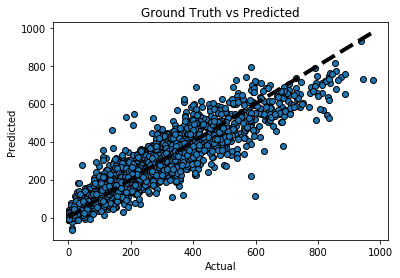

In [23]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_predicted, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

In [29]:
print('Test R2 score: %.2f' % r2_score(test_y, y_predicted, multioutput='variance_weighted'))
print('Test explained_variance_score score: %.2f' % explained_variance_score(test_y, y_predicted,
                                                                             multioutput='variance_weighted'))
print("Test Mean squared error: %.2f"% mean_squared_error(test_y, y_predicted))
print('Test mean_absolute_error score: %.2f' % mean_absolute_error(test_y, y_predicted))

print('Test max_error score: %.2f' % max_error(test_y, y_predicted))
print('Test median_absolute_error score: %.2f' % median_absolute_error(test_y, y_predicted))

Test R2 score: 0.89
Test explained_variance_score score: 0.89
Test Mean squared error: 3635.67
Test mean_absolute_error score: 39.84
Test max_error score: 484.67
Test median_absolute_error score: 23.67
